## 1. Feature Engineering and Selection

Based on previous feature engineering , we are going to make 2 model that distinguished by have or doesn't have bureau data and we will use features:
- AGE (binned)
- INCOME (binned)
- GENDER
- EDUCATION
- LOAN_PURPOSE
- HAS_APPLIED_BEFORE
- HAS INCOME VERIFICATION
- Bureau data ("LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS")

This notebook will create model for customers without bureau data

# 2. Load library and necessary functions 

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import train_test_split
from sklearn.model_selection import train_test_split
# from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, plot_roc_curve, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from lightgbm import LGBMClassifier
import xgboost as xgb

In [48]:
import joblib

def split_input_output(dataset,
                       target_column,
                       save_file = True,
                       return_file = True):
    
    output_df = dataset[target_column]
    input_df = dataset.drop([target_column],
                            axis = 1)
    
    if save_file:
        joblib.dump(output_df, "output/output_df.pkl")
        joblib.dump(input_df, "output/input_df.pkl")
    
    if return_file:
        return output_df, input_df


def split_train_test(x, y, TEST_SIZE):
    # Do not forget to stratify if classification
    x_train, x_test,\
        y_train, y_test = train_test_split(x,
                                           y,
                                           test_size=TEST_SIZE,
                                           random_state=123,
                                          stratify=y)

    return x_train, x_test, y_train, y_test

def split_data(data_input, data_ouput, save_file = False, return_file=False, TEST_SIZE=0.2):

    x_train, x_test, \
        y_train, y_test = split_train_test(
            data_input,
            data_ouput,
            TEST_SIZE)

    x_train, x_valid, \
        y_train, y_valid = split_train_test(
            x_train,
            y_train,
            TEST_SIZE)
    
    if save_file:
        joblib.dump(x_train, "output/x_train1.pkl")
        joblib.dump(y_train, "output/y_train1.pkl")
        joblib.dump(x_valid, "output/x_valid1.pkl")
        joblib.dump(y_valid, "output/y_valid1.pkl")
        joblib.dump(x_test, "output/x_test1.pkl")
        joblib.dump(y_test, "output/y_test1.pkl")

    if return_file:
        return x_train, y_train, \
            x_valid, y_valid, \
            x_test, y_test

In [49]:
def binning_features(df):
    #binning Age
    df.loc[ df['AGE'] <= 20, 'AGE'] = 0
    df.loc[(df['AGE'] > 20) & (df['AGE'] <= 34), 'AGE'] = 1
    df.loc[(df['AGE'] > 34) & (df['AGE'] <= 40), 'AGE'] = 2
    df.loc[(df['AGE'] > 40) & (df['AGE'] <= 47), 'AGE'] = 3
    df.loc[ df['AGE'] > 47, 'AGE'] = 4
    
    #income
    df.loc[ df['INCOME'] <= 4e6, 'INCOME'] = 0
    df.loc[(df['INCOME'] > 4e6) & (df['INCOME'] <= 5e6), 'INCOME'] = 1
    df.loc[(df['INCOME'] > 5e6) & (df['INCOME'] <= 6e6), 'INCOME'] = 2
    df.loc[(df['INCOME'] > 6e6) & (df['INCOME'] <= 8e6), 'INCOME'] = 3
    df.loc[(df['INCOME'] > 8e6) & (df['INCOME'] <= 11e6), 'INCOME'] = 4
    df.loc[ df['INCOME'] > 11e6, 'INCOME'] = 5

    return df

In [50]:
def one_hot_encoder(x_cat):
    df = x_cat.copy()
    index = x_cat.index
    col = x_cat.columns
    
    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    encoder.fit(x_cat)

    encoded = encoder.transform(x_cat)
    feat_names = encoder.get_feature_names(col)
    encoded = pd.DataFrame(encoded)
    encoded.index = index
    encoded.columns = feat_names
    return encoded

In [51]:
#compile all engineering
def feature_engineering(df):
    TARGET = "LOAN_WAS_PAID_BACK"
    #drop some features
    df = df.drop(["customer_id", "APPLICATION_RECEIVE_TIME", "KNOWN_ASSETS", "Score"], axis=1)
    #dropna for Income and Loan Purpose
    df = df.dropna(subset = ['INCOME', 'LOAN_PURPOSE'])
    
    #binning
    binning_features(df)
    
    #converting categorical Features
    df['GENDER'] = df['GENDER'].map( {'Male': 1, 'Female': 0} ).astype(int)
    df['HAS_APPLIED_BEFORE'] = df['HAS_APPLIED_BEFORE'].map( {'Yes': 1, 'No': 0} ).astype(int)
    df['HAS_INCOME_VERIFICATION'] = df['HAS_INCOME_VERIFICATION'].map( {'Yes': 1, 'No': 0} ).astype(int)
    
    #one hot encoding
    df_num = df.drop(['EDUCATION','LOAN_PURPOSE'], axis=1)
    df_hot = one_hot_encoder(df[['EDUCATION','LOAN_PURPOSE']])
    df_ready = df_num.join(df_hot)
    
    #split data with or without bureau data
    df_with_bureau = df_ready.dropna(subset = ['LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS'])
    df_without_bureau = df_ready[df_ready['LOANS_WITH_DELAYS'].isna() == True]
    df_without_bureau = df_ready.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])
    X_with_bureau = df_with_bureau.drop(columns=TARGET)
    X_without_bureau = df_without_bureau.drop(columns=TARGET)
    y_with_bureau = df_with_bureau[TARGET]
    y_without_bureau = df_without_bureau[TARGET]
    return X_with_bureau,X_without_bureau,y_with_bureau,y_without_bureau


def add_columns(df_raw, df_2,bureau='yes'):
    df_temp = df_2.copy()
    X_with_bureau,X_without_bureau,y_with_bureau,y_without_bureau = feature_engineering(df_raw)
    if bureau =='yes':
        mis_col = set(X_with_bureau.columns).difference(set(df_2.columns))
        print(mis_col)
    else:
        mis_col = set(X_without_bureau.columns).difference(set(df_2.columns))
        print(mis_col)
    if len(mis_col) > 0:
        for i in mis_col :
            df_temp.loc[:, i] = 0
    else:
        pass
    return df_temp

In [131]:
#compile all engineering
def feature_engineering_xb(df):
    TARGET = "LOAN_WAS_PAID_BACK"
    #drop some features
    df = df.drop(["customer_id", "APPLICATION_RECEIVE_TIME", "KNOWN_ASSETS", "Score"], axis=1)
    #dropna for Income and Loan Purpose
    df = df.dropna(subset = ['INCOME', 'LOAN_PURPOSE'])
    
    #binning
    binning_features(df)
    
    #converting categorical Features
    df['GENDER'] = df['GENDER'].map( {'Male': 1, 'Female': 0} ).astype(int)
    df['HAS_APPLIED_BEFORE'] = df['HAS_APPLIED_BEFORE'].map( {'Yes': 1, 'No': 0} ).astype(int)
    df['HAS_INCOME_VERIFICATION'] = df['HAS_INCOME_VERIFICATION'].map( {'Yes': 1, 'No': 0} ).astype(int)
    
    #one hot encoding
    df_num = df.drop(['EDUCATION','LOAN_PURPOSE'], axis=1)
    df_hot = one_hot_encoder(df[['EDUCATION','LOAN_PURPOSE']])
    df_ready = df_num.join(df_hot)
    df_without_bureau=df_ready #tambahan
    
    #split data with or without bureau data
    #df_with_bureau = df_ready.dropna(subset = ['LOANS_WITHOUT_DELAYS', 'LOANS_WITH_DELAYS'])
    #df_without_bureau = df_ready[df_ready['LOANS_WITH_DELAYS'].isna() == True]
    #df_without_bureau = df_ready.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])
    #X_with_bureau = df_with_bureau.drop(columns=TARGET)
    X_without_bureau = df_without_bureau.drop(columns=TARGET)
    #y_with_bureau = df_with_bureau[TARGET]
    y_without_bureau = df_without_bureau[TARGET]
    return X_without_bureau,y_without_bureau


def add_columns_xb(df_raw, df_2):
    df_temp = df_2.copy()
    df_raw = df_raw.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])
    X_without_bureau,y_without_bureau = feature_engineering_xb(df_raw)
    mis_col = set(X_without_bureau.columns).difference(set(df_2.columns))
    print(mis_col)
    if len(mis_col) > 0:
        for i in mis_col :
            df_temp.loc[:, i] = 0
    else:
        pass
    return df_temp

### Load all our data 

In [132]:
master = pd.read_csv("./Customer_Information.csv")
bureau = pd.read_csv("./Credit_Bureau_Data.csv")
external = pd.read_csv("./External_Score.csv")

# 3. Modelling Start

For this model, we are going to use all the available data rows and all without bureau features. To handle the imbalance in data label, we are going to take all data with class 0 in our target column, and randomly sample the same number of rows with label 1 to get 50:50 proportions of each label

### 3.1 Train test validation split

In [133]:
# merge master and bureau and external data
df = pd.merge(master, bureau, on='customer_id', how='left')
df = pd.merge(df, external, on='customer_id', how='left')
df.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,LOANS_WITHOUT_DELAYS,LOANS_WITH_DELAYS,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,3.0,3.0,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,3.0,0.0,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,2.0,1.0,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,1.0,0.0,40000000.0,0.81


In [134]:
df.shape

(6588, 14)

In [135]:
# get all data without bureau
df_1 = df.drop(columns=[ "LOANS_WITHOUT_DELAYS", "LOANS_WITH_DELAYS"])

# get all data with label 0
df_2 = df_1.loc[(df_1.LOAN_WAS_PAID_BACK == 0)]

# get all labeled 1 data with the same number of row as label 0 data
df_3 = df_1.loc[df_1.LOAN_WAS_PAID_BACK == 1, :].sample(n = df_2.shape[0])
df_final = pd.concat([df_2, df_3], ignore_index=True)
df_final.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,40000000.0,0.81
1,36500,29,14000000.0,Female,Bachelor Degree,Renovation,19:30:00,Yes,Yes,0,NaN,0.86
2,36512,40,6000000.0,Female,Bachelor Degree,Working Capital,10:31:00,Yes,Yes,0,10000000.0,0.77
3,36526,29,6000000.0,Male,Bachelor Degree,Working Capital,10:35:00,Yes,Yes,0,10000000.0,NaN
4,36528,44,10000000.0,Female,Bachelor Degree,Credit card,07:01:00,No,Yes,0,NaN,0.77


In [136]:
df_final.LOAN_WAS_PAID_BACK.value_counts()

0    963
1    963
Name: LOAN_WAS_PAID_BACK, dtype: int64

In [137]:
# do the splitting
TARGET = "LOAN_WAS_PAID_BACK"
TEST_SIZE = 0.3

output_df, input_df = split_input_output(
                            df_final,
                            TARGET, save_file = False)

x_train, y_train, x_valid, y_valid, x_test, y_test = split_data(input_df,
                                                                    output_df,
                                                                    False,
                                                                   True,
                                                                   TEST_SIZE)

In [138]:
# check if stratify is correct
print(y_train.value_counts())
print("-------------------------------------")
print(y_valid.value_counts())
print("-------------------------------------")
print(y_test.value_counts())

1    472
0    471
Name: LOAN_WAS_PAID_BACK, dtype: int64
-------------------------------------
0    203
1    202
Name: LOAN_WAS_PAID_BACK, dtype: int64
-------------------------------------
1    289
0    289
Name: LOAN_WAS_PAID_BACK, dtype: int64


In [139]:
# check if stratify is correct
print(y_train.value_counts(normalize = True))
print("-------------------------------------")
print(y_valid.value_counts(normalize = True))
print("-------------------------------------")
print(y_test.value_counts(normalize = True))

1    0.50053
0    0.49947
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
0    0.501235
1    0.498765
Name: LOAN_WAS_PAID_BACK, dtype: float64
-------------------------------------
1    0.5
0    0.5
Name: LOAN_WAS_PAID_BACK, dtype: float64


In [140]:
x_train.shape

(943, 11)

### 3.2 Load the preprocess training, validation and testing data  

We are going to used previously pickled datasets which gives the most optimum results

In [141]:
x_train = joblib.load("./output/x_train1.pkl")
y_train = joblib.load("./output/y_train1.pkl")
x_valid = joblib.load("./output/x_valid1.pkl")
y_valid = joblib.load("./output/y_valid1.pkl")
x_test = joblib.load("./output/x_test1.pkl")
y_test = joblib.load("./output/y_test1.pkl")

# 4. Feature preprocessing 

### 4.1 Train engineering 

In [142]:
df_train = pd.concat([x_train, pd.DataFrame(y_train)], axis = 1)

In [143]:
# This is our final feature
X_train_without_bureau,y_train_without_bureau = feature_engineering_xb(df_train)

In [144]:
X_train_without_bureau = add_columns_xb(df,X_train_without_bureau)

{'LOAN_PURPOSE_Car/Motorcycle'}


In [145]:
print(f' Data Train Without Bureau has {X_train_without_bureau.shape[1]} Features')

 Data Train Without Bureau has 22 Features


In [147]:
X_train_without_bureau.shape

(939, 22)

### 4.2 Validation engineering 

In [148]:
df_valid = pd.concat([x_valid, pd.DataFrame(y_valid)], axis = 1)

In [149]:
# This is our final feature
X_valid_without_bureau,y_valid_without_bureau = feature_engineering_xb(df_valid)

In [151]:
X_valid_without_bureau = add_columns_xb(df,X_valid_without_bureau)

{'LOAN_PURPOSE_Car/Motorcycle'}


In [157]:
print(f' Data Validation Without Bureau has {X_valid_without_bureau.shape[1]} Features')

 Data Validation Without Bureau has 22 Features


### 4.3 Test engineering 

In [153]:
df_test = pd.concat([x_test, pd.DataFrame(y_test)], axis = 1)

In [154]:
# This is our final feature
X_test_without_bureau,y_test_without_bureau = feature_engineering_xb(df_test)

In [155]:
X_test_without_bureau = add_columns_xb(df,X_test_without_bureau)

{'LOAN_PURPOSE_Car/Motorcycle'}


In [158]:
print(f' Data Test Without Bureau has {X_test_without_bureau.shape[1]} Features')

 Data Test Without Bureau has 22 Features


# 5. ML training 

### 5.1 Preprocessing the data 

In [159]:
# Changing everything to float and replacing infinities
for c in X_train_without_bureau.columns:
  X_train_without_bureau[c] = X_train_without_bureau[c].astype(np.float64)
X_train_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [160]:
# Changing everything to float and replacing infinities
for c in X_valid_without_bureau.columns:
  X_valid_without_bureau[c] = X_valid_without_bureau[c].astype(np.float64)
X_valid_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [161]:
# Changing everything to float and replacing infinities
for c in X_test_without_bureau.columns:
  X_test_without_bureau[c] = X_test_without_bureau[c].astype(np.float64)
X_test_without_bureau.replace([np.inf, -np.inf], np.nan, inplace=True)

In [162]:
X_train_without_bureau.isnull().sum()

AGE                                        0
INCOME                                     0
GENDER                                     0
HAS_APPLIED_BEFORE                         0
HAS_INCOME_VERIFICATION                    0
EDUCATION_Bachelor Degree                  0
EDUCATION_Diploma                          0
EDUCATION_High School                      0
EDUCATION_Master's Degree/Post graduate    0
EDUCATION_Other                            0
LOAN_PURPOSE_Bills                         0
LOAN_PURPOSE_Credit card                   0
LOAN_PURPOSE_Education                     0
LOAN_PURPOSE_Electronic unsecured loan     0
LOAN_PURPOSE_Holiday                       0
LOAN_PURPOSE_Housing loan                  0
LOAN_PURPOSE_Investment                    0
LOAN_PURPOSE_Other                         0
LOAN_PURPOSE_Renovation                    0
LOAN_PURPOSE_Venture capital               0
LOAN_PURPOSE_Working Capital               0
LOAN_PURPOSE_Car/Motorcycle                0
dtype: int

In [163]:
# Fixing column names that contains [,],or < for XGBoost model
import re
regex = re.compile(r"\[|\]|<", re.IGNORECASE)
X_train_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_without_bureau.columns.values]
X_valid_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_valid_without_bureau.columns.values]
X_test_without_bureau.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_test_without_bureau.columns.values]

### 5.1 Create baseline models 

We are going to start with evaluating baseline on various model with training data , and test the performance on validation data

In [164]:
# Check the baseline model
def baseline_model(X_train,y_train):
  clf_logreg = LogisticRegression().fit(X_train,y_train)
  clf_rf = RandomForestClassifier().fit(X_train,y_train)
  clf_tree = DecisionTreeClassifier().fit(X_train,y_train)
  clf_knn = KNeighborsClassifier().fit(X_train,y_train)
  clf_lgbm = LGBMClassifier().fit(X_train,y_train)
  clf_xgb = xgb.XGBClassifier().fit(X_train,y_train)

  gini_logreg = (2*(roc_auc_score(y_train, clf_logreg.predict_proba(X_train)[:, 1])))-1
  gini_rf = (2*(roc_auc_score(y_train, clf_rf.predict_proba(X_train)[:, 1])))-1
  gini_tree = (2*(roc_auc_score(y_train, clf_tree.predict_proba(X_train)[:, 1])))-1
  gini_knn = (2*(roc_auc_score(y_train, clf_knn.predict_proba(X_train)[:, 1])))-1
  gini_lgbm = (2*(roc_auc_score(y_train, clf_lgbm.predict_proba(X_train)[:, 1])))-1
  gini_xgb = (2*(roc_auc_score(y_train, clf_xgb.predict_proba(X_train)[:, 1])))-1

  print("Gini Performance Evaluation\n")
  print(f"Logistic Regression Gini : {gini_logreg}")
  print(f"Random Forest Gini       : {gini_rf}")
  print(f"Decision Tree Gini       : {gini_tree}")
  print(f"KNN Classifier Gini      : {gini_knn}")
  print(f"LGBM Gini                : {gini_lgbm}")
  print(f"XGBoost Gini             : {gini_xgb}")

  return clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb
 
clf_logreg, clf_rf, clf_tree, clf_knn, clf_lgbm, clf_xgb = baseline_model(X_train_without_bureau,y_train_without_bureau)

Gini Performance Evaluation

Logistic Regression Gini : 0.27739418409472405
Random Forest Gini       : 0.8576237354262126
Decision Tree Gini       : 0.8678038379530919
KNN Classifier Gini      : 0.46768135008846357
LGBM Gini                : 0.6633443723631085
XGBoost Gini             : 0.7755568661253007


### 5.2 Hyperparameter tuning on best baseline model

Taking top 3 models based on the training gini

In [165]:
%%time

clf_xgb = xgb.XGBClassifier()
clf_tree = DecisionTreeClassifier()
clf_rf = RandomForestClassifier()

# Define evaluation
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=420)

# Define search space
space_tree = dict()
space_rf = dict()
space_xgb = [
  {
    'clf__n_estimators': [50, 100, 150, 200],
    'clf__learning_rate': [0.01, 0.1, 0.2, 0.3],
    'clf__max_depth': range(3, 10),
    'clf__colsample_bytree': [i/10.0 for i in range(1, 3)],
    'clf__gamma': [i/10.0 for i in range(3)],
#     'fs__score_func': [chi2],
    'fs__k': [10],
  }
]

max_depth = [int(x) for x in np.linspace(10, 110, num = 11)] #RF
max_depth.append(None) #RF
space_rf['max_depth'] = max_depth # RF
space_rf['min_samples_split'] = [2, 5, 10] # RF
space_rf['min_samples_leaf'] = [1, 2, 4] # RF

space_tree['max_depth'] = [2, 3, 5, 10, 20] #DT
space_tree['min_samples_leaf'] = [5, 10, 20, 50, 100] #DT
space_tree['criterion'] = ["gini", "entropy"] #DT

# Define search
search_tree = RandomizedSearchCV(clf_tree, space_tree, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)
search_rf = RandomizedSearchCV(clf_rf, space_rf, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)
search_xgb = RandomizedSearchCV(clf_xgb, space_xgb, n_iter=30, scoring='roc_auc', n_jobs=30, cv=cv, random_state=1)

# Execute search
result_tree = search_tree.fit(X_train_without_bureau,y_train_without_bureau)
result_rf = search_rf.fit(X_train_without_bureau,y_train_without_bureau)
result_xgb = search_xgb.fit(X_train_without_bureau,y_train_without_bureau)

# Summarize result
print('Best Score tree: %s' % ((result_tree.best_score_ * 2) - 1))
print('Best Hyperparameters: %s' % result_tree.best_params_)

print('Best Score rf: %s' % ((result_rf.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_rf.best_params_)

print('Best Score xgb: %s' % ((result_xgb.best_score_*2) - 1))
print('Best Hyperparameters: %s' % result_xgb.best_params_)

Best Score tree: 0.19199618162851562
Best Hyperparameters: {'min_samples_leaf': 50, 'max_depth': 3, 'criterion': 'entropy'}
Best Score rf: 0.18318686401480133
Best Hyperparameters: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None}
Best Score xgb: 0.11380370815045171
Best Hyperparameters: {'fs__k': 10, 'clf__n_estimators': 200, 'clf__max_depth': 8, 'clf__learning_rate': 0.3, 'clf__gamma': 0.0, 'clf__colsample_bytree': 0.1}
Wall time: 1min 6s


### 5.3 Evaluate on validation data 

In [166]:
dt_valid = DecisionTreeClassifier(
    min_samples_leaf = 50, 
    max_depth = 3, 
    criterion = 'entropy').fit(X_train_without_bureau,y_train_without_bureau)

rf_valid = RandomForestClassifier(
    min_samples_split = 10, 
    min_samples_leaf = 4, 
    max_depth = None).fit(X_train_without_bureau,y_train_without_bureau)

xgb_valid = xgb.XGBClassifier(
    fs__k= 10, 
    n_estimators= 200, 
    max_depth= 8, 
    learning_rate= 0.3, 
    gamma= 0.0, 
    colsample_bytree= 0.1,
    verbosity = 0).fit(X_train_without_bureau,y_train_without_bureau)

def gini_value(x, y, model):
    return (2*(roc_auc_score(y, model.predict_proba(x)[:, 1])))-1

print("GINI validation data for Decision Tree :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, dt_valid))
print("GINI validation data for Random Forest :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, rf_valid))
print("GINI validation data for XGBOOST :" , gini_value(X_valid_without_bureau,y_valid_without_bureau, xgb_valid))

GINI validation data for Decision Tree : 0.20382701685768745
GINI validation data for Random Forest : 0.2086541079783153
GINI validation data for XGBOOST : 0.26796544297843883


Using Xgboost model since it provide highest gini in validation data

In [167]:
from sklearn.metrics import classification_report

y_pred_train = xgb_valid.predict(X_train_without_bureau)

print(classification_report(y_train_without_bureau, y_pred_train))

              precision    recall  f1-score   support

           0       0.63      0.66      0.64       469
           1       0.64      0.62      0.63       470

    accuracy                           0.64       939
   macro avg       0.64      0.64      0.64       939
weighted avg       0.64      0.64      0.64       939



In [168]:
from sklearn.metrics import classification_report

y_pred_valid = xgb_valid.predict(X_valid_without_bureau)

print(classification_report(y_valid_without_bureau, y_pred_valid))

              precision    recall  f1-score   support

           0       0.62      0.55      0.58       203
           1       0.59      0.66      0.62       199

    accuracy                           0.60       402
   macro avg       0.60      0.60      0.60       402
weighted avg       0.60      0.60      0.60       402



In [169]:
#dengan data validation yang sudah di resample
from sklearn.metrics import classification_report

y_pred_valid = xgb_valid.predict(X_valid_without_bureau_rs)

print(classification_report(y_valid_without_bureau_rs, y_pred_valid))

              precision    recall  f1-score   support

           0       0.56      0.30      0.39      1170
           1       0.52      0.76      0.62      1170

    accuracy                           0.53      2340
   macro avg       0.54      0.53      0.51      2340
weighted avg       0.54      0.53      0.51      2340



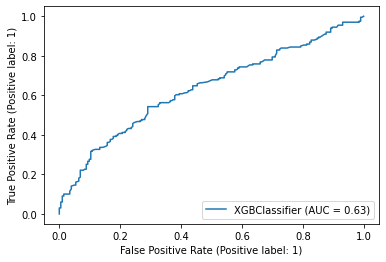

In [170]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_valid,X_valid_without_bureau,y_valid_without_bureau)
plt.show()

### 5.4 Retrain model with combined validation and train data 

We are going to retrain the model with combination of our validation and training data, then test the performance against our test dataset

In [171]:
# combine validation and train data
x_combine = pd.concat([X_train_without_bureau, X_valid_without_bureau]).reset_index(drop = True)
y_combine = pd.concat([y_train_without_bureau, y_valid_without_bureau]).reset_index(drop = True)

xgb_retrain= xgb.XGBClassifier(f
    fs__k= 10, 
    n_estimators= 200, 
    max_depth= 8, 
    learning_rate= 0.3, 
    gamma= 0.0, 
    colsample_bytree= 0.1,
    verbosity = 0).fit(x_combine,y_combine)

# rf_retrain = RandomForestClassifier(
#     min_samples_split = 5, 
#     min_samples_leaf = 4, 
#     max_depth = 80).fit(x_combine,y_combine)

# dt_retrain = DecisionTreeClassifier(
#     min_samples_leaf = 50, 
#     max_depth = 3, 
#     criterion = 'gini').fit(x_combine,y_combine)

print("GINI validation combine for XGBOOST :" , gini_value(x_combine, y_combine, xgb_retrain))

GINI validation combine for XGBOOST : 0.37660376183358246


In [172]:
from sklearn.metrics import classification_report

y_pred_comb = xgb_retrain.predict(x_combine)

print(classification_report(y_combine, y_pred_comb))

              precision    recall  f1-score   support

           0       0.63      0.67      0.65       672
           1       0.65      0.60      0.62       669

    accuracy                           0.64      1341
   macro avg       0.64      0.64      0.64      1341
weighted avg       0.64      0.64      0.64      1341



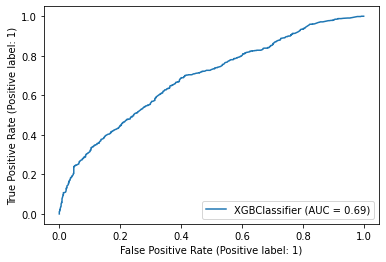

In [173]:
from sklearn.metrics import plot_roc_curve
plot_roc_curve(xgb_retrain, x_combine, y_combine)
plt.show()

# 6. Evaluate Model Performance  

### 6.1 Test model performance on testing dataset  

We now test the model on our hold out (test) dataset

In [174]:
y_pred_test_without_bureau = xgb_retrain.predict(X_test_without_bureau)
print(classification_report(y_test_without_bureau, y_pred_test_without_bureau))

print("GINI test for retrain XGBOOST :" , gini_value(X_test_without_bureau, y_test_without_bureau, xgb_retrain))

              precision    recall  f1-score   support

           0       0.59      0.60      0.59       289
           1       0.59      0.58      0.58       288

    accuracy                           0.59       577
   macro avg       0.59      0.59      0.59       577
weighted avg       0.59      0.59      0.59       577

GINI test for retrain XGBOOST : 0.22784505959246437


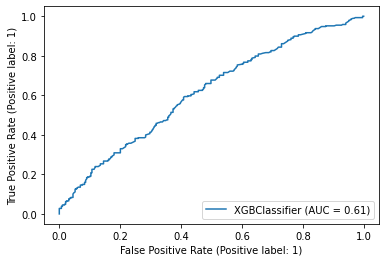

In [175]:
plot_roc_curve(xgb_retrain, X_test_without_bureau,y_test_without_bureau)
plt.show()

### 6.2 Decile Analysis

In order to minimise the risk, we are going to rank customer based on their predicted probability of paying back their loan through decile analysis, and then set a threshold of which rank we will accept for a loan

In [178]:
y_pred_test_prob = xgb_retrain.predict_proba(X_test_without_bureau)
df_decile=X_test_without_bureau.copy()
df_decile['proba']=y_pred_test_prob[:,1]
df_decile['act']=y_test_without_bureau
df_decile.sort_values(by=['proba'], ascending=True, inplace=True)
df_decile.head()

,AGE,INCOME,GENDER,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,EDUCATION_Bachelor Degree,EDUCATION_Diploma,EDUCATION_High School,EDUCATION_Master's Degree/Post graduate,EDUCATION_Other,...,LOAN_PURPOSE_Holiday,LOAN_PURPOSE_Housing loan,LOAN_PURPOSE_Investment,LOAN_PURPOSE_Other,LOAN_PURPOSE_Renovation,LOAN_PURPOSE_Venture capital,LOAN_PURPOSE_Working Capital,LOAN_PURPOSE_Car/Motorcycle,proba,act
315,3.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.145400,0
1276,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166431,1
1322,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.203139,1
44,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.225139,0
434,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.232418,0


In [179]:
df_decile.reset_index(inplace=True)
del df_decile['index']
df_decile.reset_index(inplace=True)

In [180]:
df_decile['decile']=pd.cut(df_decile['index'],10,labels=False,duplicates='drop')+1
df_decile.head()

,index,AGE,INCOME,GENDER,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,EDUCATION_Bachelor Degree,EDUCATION_Diploma,EDUCATION_High School,EDUCATION_Master's Degree/Post graduate,...,LOAN_PURPOSE_Housing loan,LOAN_PURPOSE_Investment,LOAN_PURPOSE_Other,LOAN_PURPOSE_Renovation,LOAN_PURPOSE_Venture capital,LOAN_PURPOSE_Working Capital,LOAN_PURPOSE_Car/Motorcycle,proba,act,decile
0,0,3.0,3.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.145400,0,1
1,1,2.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.166431,1,1
2,2,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.203139,1,1
3,3,3.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.225139,0,1
4,4,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.232418,0,1


In [181]:
df_decile[['index','act']].groupby(['act']).count()

,index
act,
0,289
1,288


In [182]:
df_decile_2=df_decile.groupby(['decile','act'],as_index=True)[['index']].count().sort_values(by=['decile','act'], ascending=True)
pd.DataFrame(df_decile_2.groupby("act")['index'].agg("cumsum"))

index
decile act       
1      0       42
       1       16
2      0       76
       1       40
3      0      108
       1       65
4      0      139
       1       92
5      0      171
       1      118
6      0      192
       1      154
7      0      219
       1      185
8      0      247
       1      214
9      0      270
       1      249
10     0      289
       1      288

We can see that our model can predict 59% (171/289) of the default customer from top 5 decile. We can then set a threshold that each customers we scored who fall on or below this 5th decile will be rejected for a loan.

Below we will compute the probabilty range for each customer and set the threshold accordingly

In [185]:
df_decile_3=df_decile[['decile','proba']].groupby(['decile'],as_index=True)[['proba']].min().sort_values(by=['decile'], ascending=True)
df_decile_3.rename(columns={'proba':'min_proba'},inplace=True)
df_decile_3['max_proba']=df_decile[['decile','proba']].groupby(['decile'],as_index=True)[['proba']].max().sort_values(by=['decile'], ascending=True)
df_decile_3.head(20)

,min_proba,max_proba
decile,,
1,0.145400,0.320198
2,0.320198,0.374064
3,0.374842,0.406855
4,0.408132,0.441880
5,0.441880,0.495328
6,0.497226,0.537244
7,0.538341,0.571226
8,0.571226,0.616764
9,0.616863,0.711112


We will our probabilty of paying back threshold at 0.495

### 6.3 Performance on all data with bureau 

Finally, we will test how the model perform in predicting probability of paying back their loan agains all the data that we have 

In [186]:
df_1.head()

,customer_id,AGE,INCOME,GENDER,EDUCATION,LOAN_PURPOSE,APPLICATION_RECEIVE_TIME,HAS_APPLIED_BEFORE,HAS_INCOME_VERIFICATION,LOAN_WAS_PAID_BACK,KNOWN_ASSETS,Score
0,36493,40,10000000.0,Female,Diploma,Working Capital,09:07:00,No,Yes,1,40000000.0,0.77
1,36494,39,15000000.0,Female,Bachelor Degree,Other,15:15:00,No,Yes,1,20000000.0,0.93
2,36495,28,15000000.0,Male,Bachelor Degree,Renovation,07:13:00,No,Yes,1,NaN,NaN
3,36496,28,4000000.0,Male,Bachelor Degree,Renovation,12:05:00,Yes,Yes,1,0.0,0.78
4,36497,38,10000000.0,Male,Diploma,Renovation,14:35:00,Yes,Yes,0,40000000.0,0.81


In [188]:
x_all, y_all = feature_engineering_xb(df_1)

In [190]:
x_all[x_all.columns[pd.Series(x_all.columns).str.startswith('LOAN_PURPOSE')]]

,LOAN_PURPOSE_Bills,LOAN_PURPOSE_Car/Motorcycle,LOAN_PURPOSE_Credit card,LOAN_PURPOSE_Education,LOAN_PURPOSE_Electronic unsecured loan,LOAN_PURPOSE_Holiday,LOAN_PURPOSE_Housing loan,LOAN_PURPOSE_Investment,LOAN_PURPOSE_Other,LOAN_PURPOSE_Renovation,LOAN_PURPOSE_Venture capital,LOAN_PURPOSE_Working Capital
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
6583,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
6584,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6585,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
6586,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [191]:
# Changing everything to float and replacing infinities
for c in x_all.columns:
    x_all[c] = x_all[c].astype(np.float64)
x_all.replace([np.inf, -np.inf], np.nan, inplace=True)

x_all.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in x_all.columns.values]

### performance

In [192]:
y_pred = xgb_retrain.predict(x_all)

print(classification_report(y_all, y_pred))

print("GINI all data for retrain XGBOOST :" , gini_value(x_all, y_all, xgb_retrain))

              precision    recall  f1-score   support

           0       0.21      0.32      0.25       961
           1       0.87      0.80      0.83      5576

    accuracy                           0.73      6537
   macro avg       0.54      0.56      0.54      6537
weighted avg       0.77      0.73      0.75      6537

GINI all data for retrain XGBOOST : 0.20927283123599416


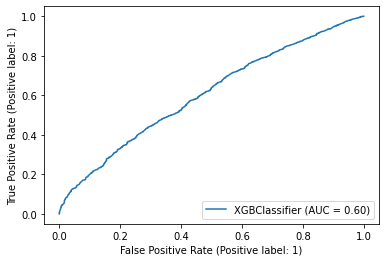

In [193]:
plot_roc_curve(xgb_retrain, x_all, y_all)
plt.show()

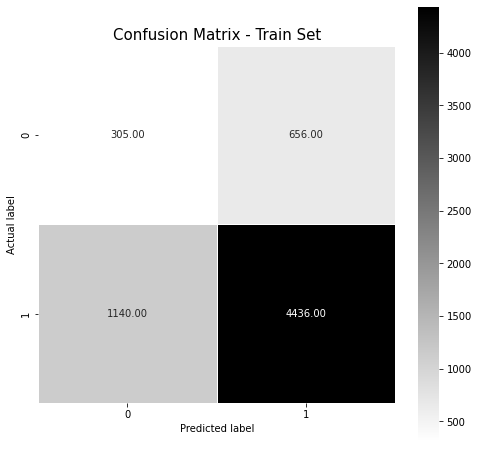

In [194]:
from sklearn import metrics
cm = metrics.confusion_matrix(y_all, y_pred)
plt.figure(figsize=(8,8))
sns.heatmap(cm, annot=True, fmt=".2f", linewidths=.5, square =True, cmap = 'binary');
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
all_sample_title = 'Confusion Matrix - Train Set'
plt.title(all_sample_title, size = 15)
plt.show()

### 6.4 Save the model for serving

In [195]:
joblib.dump(xgb_retrain, "output/xgb_retrain_no_bureau.pkl")

['output/xgb_retrain_no_bureau.pkl']

In [196]:
c = joblib.load("output/xgb_retrain_no_bureau.pkl")

In [258]:
t = x_all.iloc[[0],:]

array([[0.46126002, 0.53874   ]], dtype=float32)

In [197]:
c.predict(x_all.iloc[[0],:])[0]

1